In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import geopandas as gpd

#FILE = 'METR-LA/metr-la.h5'
data_path = 'PEMS-BAY'
FILE = f'{data_path}/pems-bay.h5'
#locations_file = 'METR-LA/graph_sensor_locations.csv'
locations_file = f'{data_path}/graph_sensor_locations_bay.csv'
alpha = 0.1


with pd.HDFStore(FILE) as store:
    print(store.keys())
    df = store[store.keys()[0]]
    
df.replace(0, np.nan, inplace=True)

['/speed']


In [2]:
def is_bimodal(data, alpha):
    kde_values = sns.kdeplot(data, bw_adjust = 2).get_lines()[0].get_data()
    mode = kde_values[0][np.argmax(kde_values[1])]
    local_minima_indices = argrelextrema(kde_values[1], np.less)
    valley = kde_values[0][local_minima_indices]
    threshold = 0
    proportion = 0
    for v in valley:
        thresh = v
        if thresh < mode - 10:
            prop = sum(data < thresh)/len(data.dropna())
            if abs(prop - 0.5) < abs(proportion - 0.5):
                proportion = prop
                threshold = thresh
    if min(proportion, 1 - proportion) > alpha:
        print(f"threshold: {threshold}, prop: {proportion}, mode: {mode}")
        plt.hist(data, bins = 100)
        plt.axvline(x=threshold, color='red', linestyle='--')
        plt.show()
    plt.clf()
    return min(proportion, 1 - proportion)

threshold: 47.035425113267834, prop: 0.1271394581318597, mode: 64.04392717330347


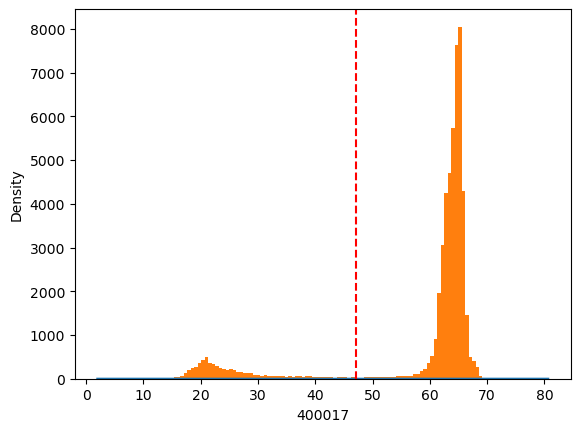

threshold: 42.15921118132925, prop: 0.10899182561307902, mode: 65.34343480791401


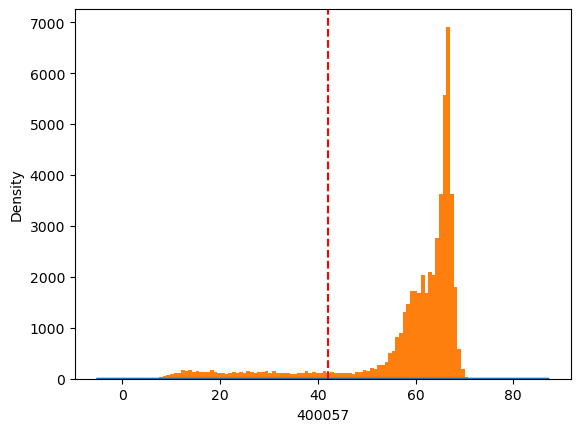

threshold: 39.49167320496982, prop: 0.14928237009747486, mode: 65.7752549938228


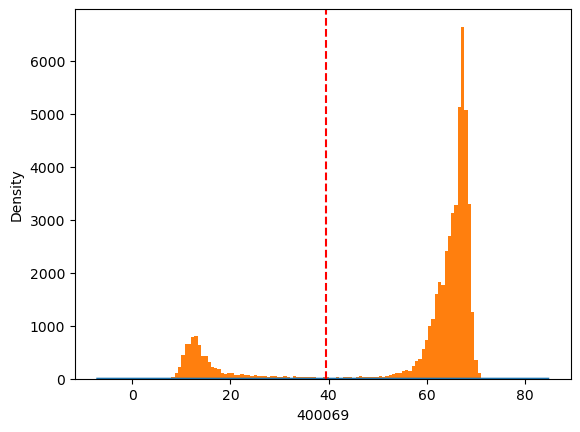

threshold: 44.649253249106515, prop: 0.10486223040908742, mode: 66.22858393509102


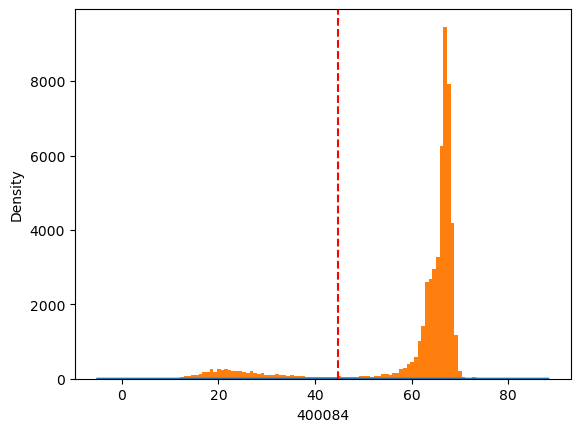

threshold: 47.90810980892199, prop: 0.11318980735282831, mode: 67.51822797618442


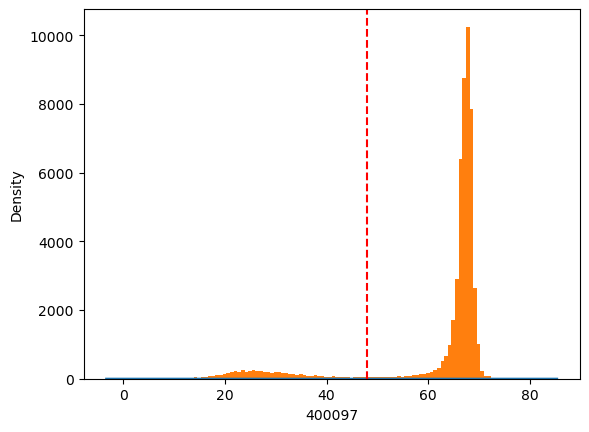

threshold: 40.621968763833046, prop: 0.14656049122133744, mode: 65.84808402927135


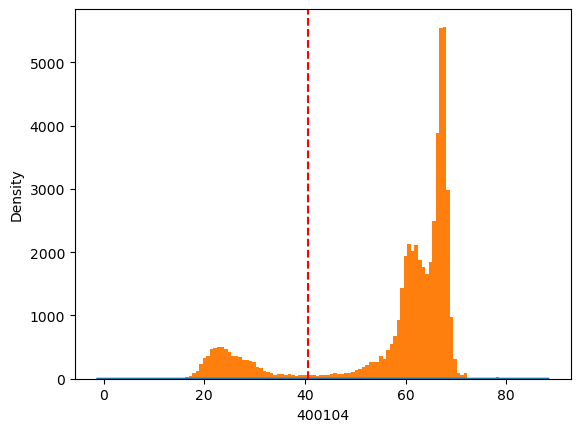

threshold: 38.39219125879348, prop: 0.11106207425885062, mode: 67.86507284338761


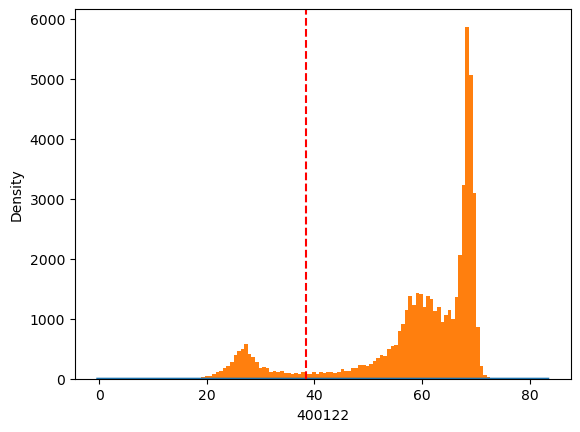

threshold: 48.367507447350974, prop: 0.162988832175615, mode: 64.16252896192046


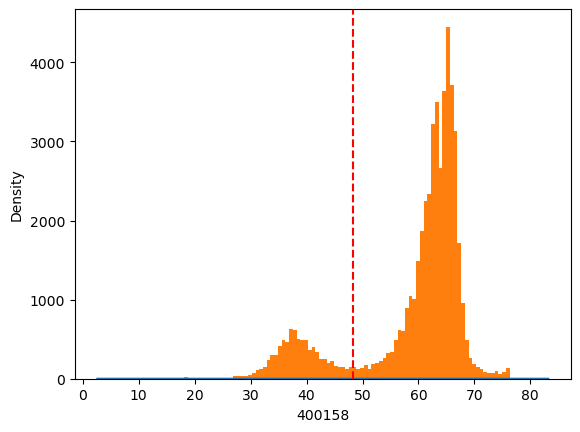

threshold: 40.61129889615679, prop: 0.18509421652530988, mode: 64.92090772690246


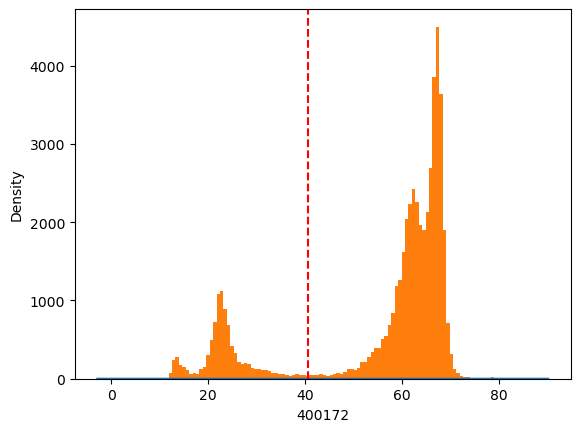

threshold: 47.246061575114545, prop: 0.12493763671949956, mode: 70.10928551442198


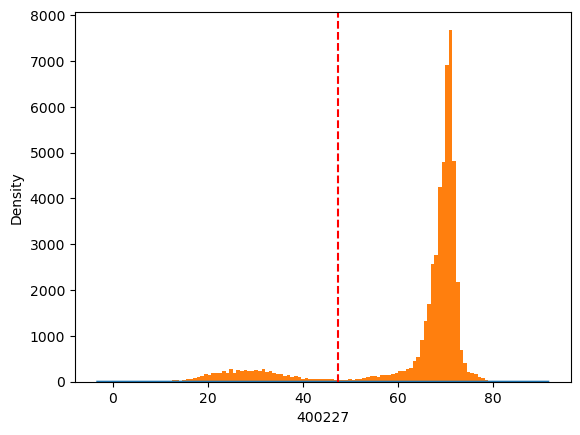

threshold: 45.53828899708646, prop: 0.12365436647285706, mode: 65.92472615847524


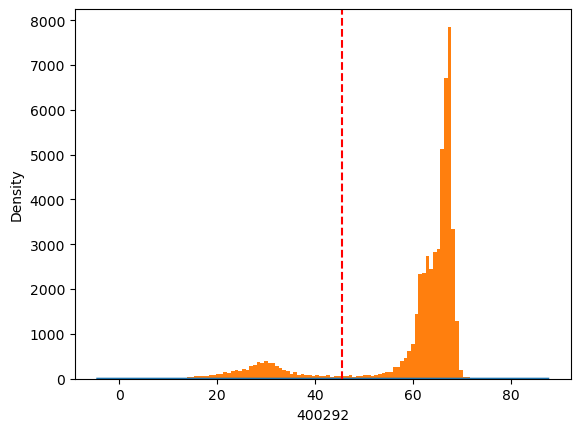

threshold: 46.50994452914584, prop: 0.10505411006216901, mode: 66.70721308096445


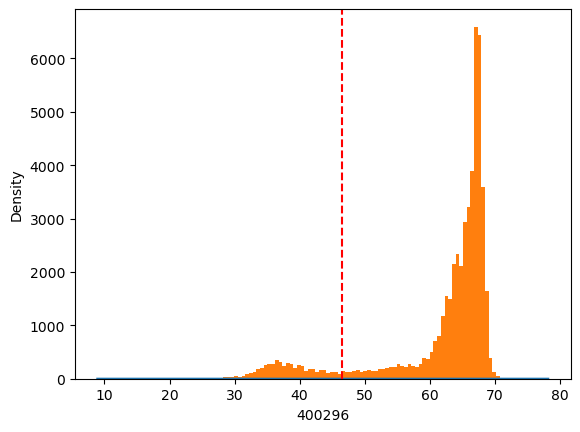

threshold: 50.75425883107839, prop: 0.10633970373781564, mode: 68.14090920998802


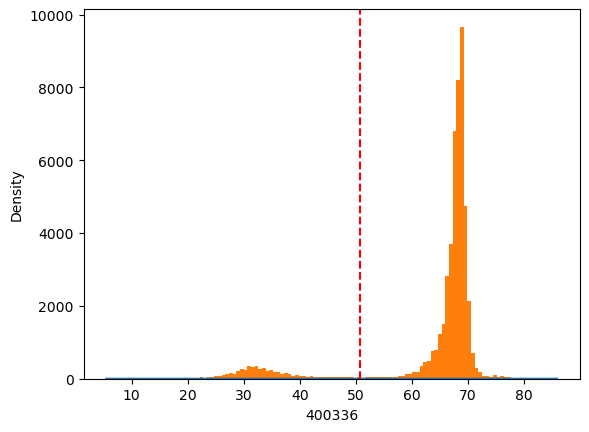

threshold: 37.88587171069889, prop: 0.13445265278710544, mode: 63.42571162176002


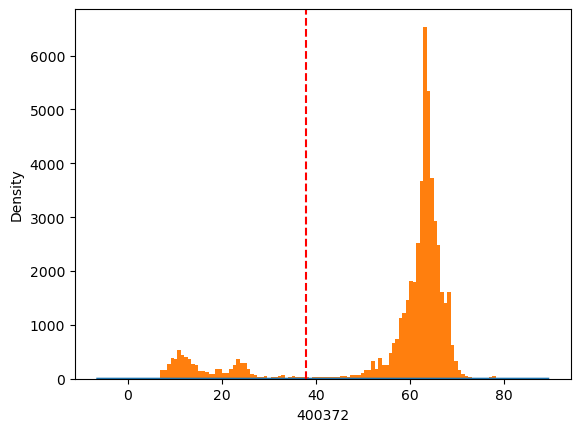

threshold: 46.00804128959848, prop: 0.1394799961623333, mode: 70.44486640276111


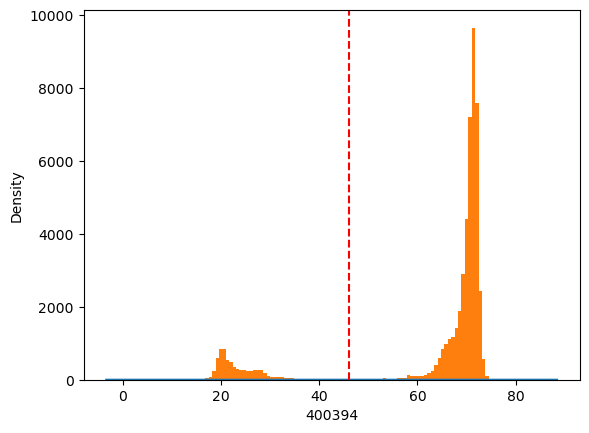

threshold: 42.408843777834605, prop: 0.10135472233948652, mode: 66.98209474276739


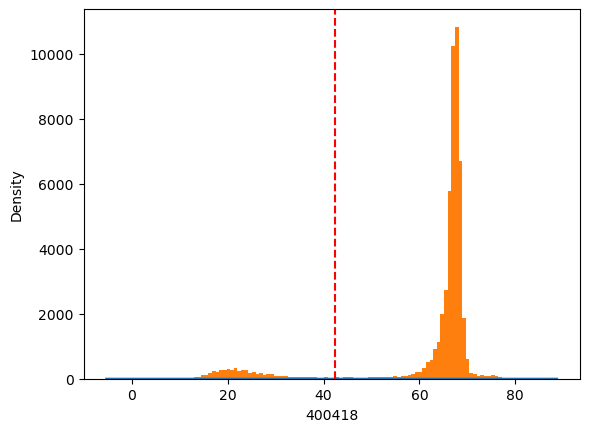

threshold: 46.07389515776491, prop: 0.11574624860881913, mode: 65.89286442035409


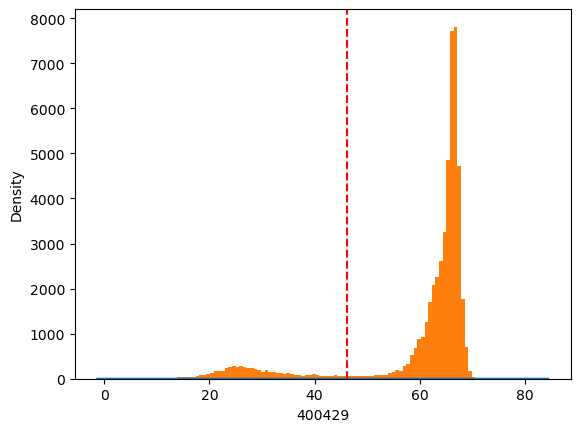

threshold: 43.02396337390506, prop: 0.10497735820093637, mode: 66.99054129303312


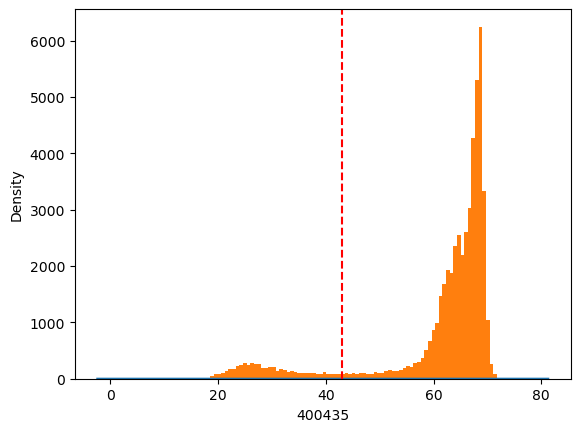

threshold: 43.028969439109716, prop: 0.13096037609133646, mode: 68.93326450148099


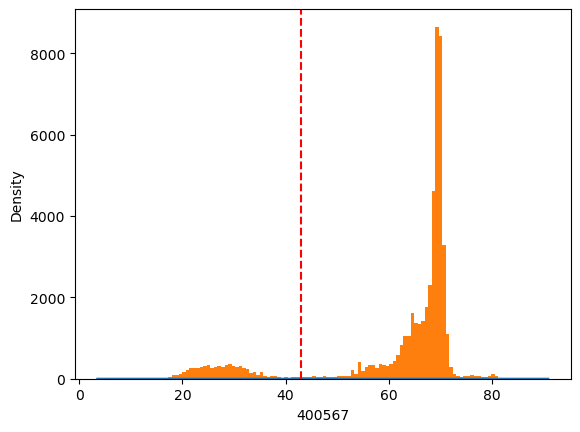

threshold: 44.71958031205301, prop: 0.10756979756308165, mode: 64.11118655311321


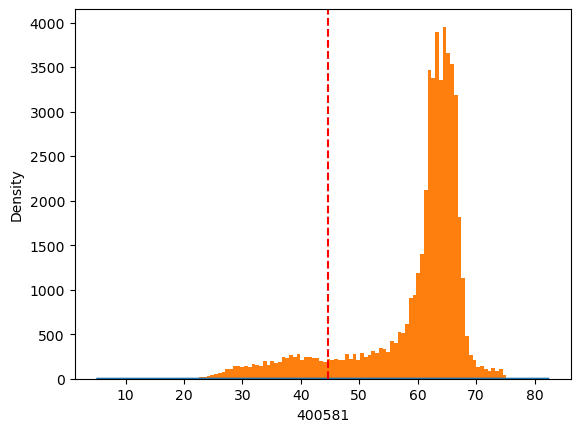

threshold: 40.701329151309224, prop: 0.11846877098723976, mode: 66.69269712220694


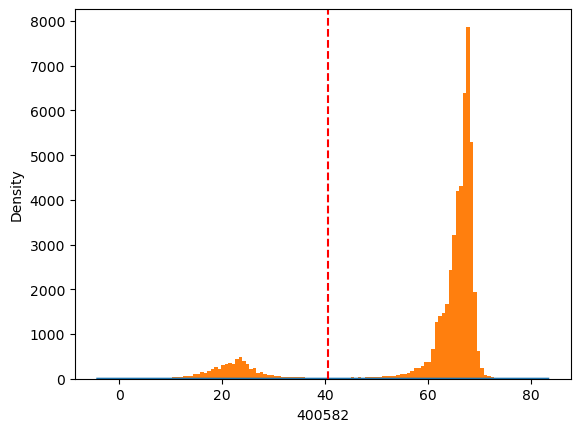

threshold: 40.62259140804128, prop: 0.1847068982058908, mode: 65.63753652350083


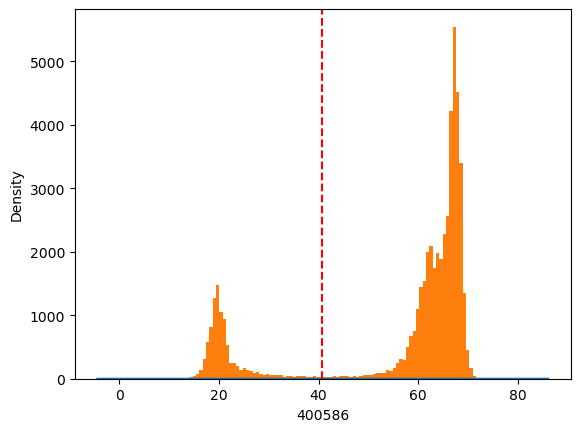

threshold: 47.12261594569016, prop: 0.10075793917298283, mode: 66.77602339052291


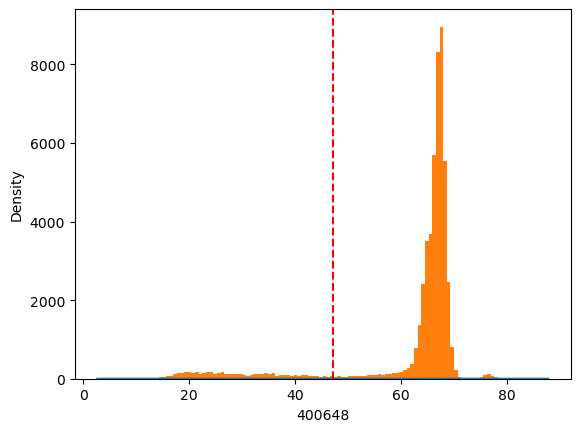

threshold: 43.36498216010689, prop: 0.11380818973788233, mode: 66.66209595015017


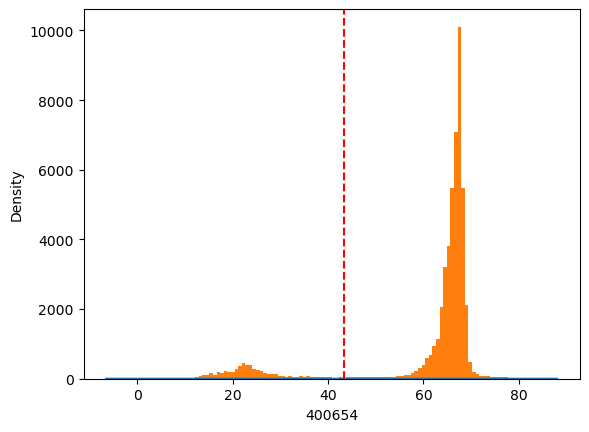

threshold: 39.680008893766185, prop: 0.11219633879571708, mode: 61.67911951714755


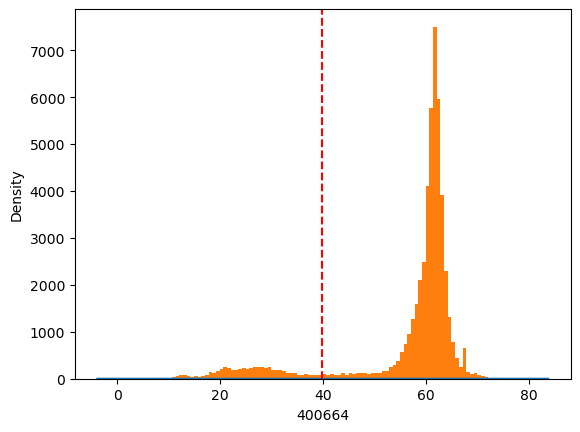

threshold: 39.38505385320716, prop: 0.10568731291733824, mode: 65.84550675845293


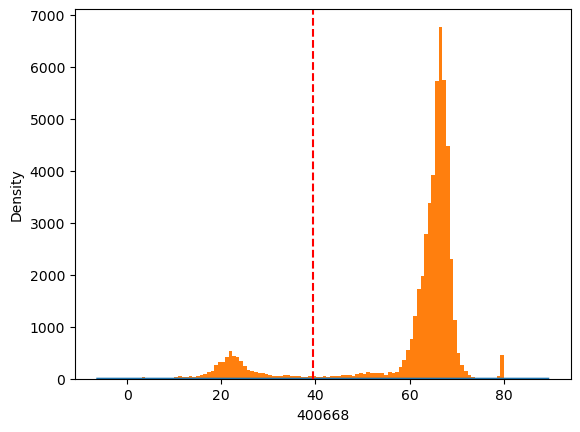

threshold: 44.365661051604, prop: 0.10164060251367169, mode: 68.1756066762482


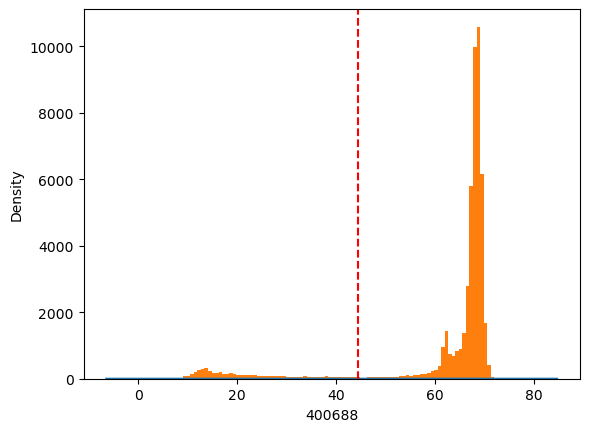

threshold: 47.234698187136146, prop: 0.1307109277559244, mode: 65.52732920357255


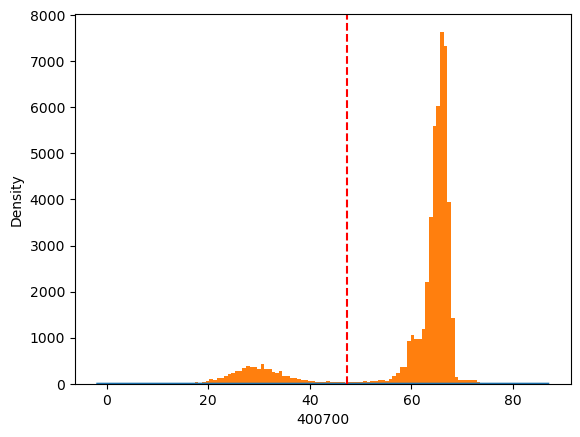

threshold: 48.308366942172114, prop: 0.10800905671962545, mode: 64.92575047453393


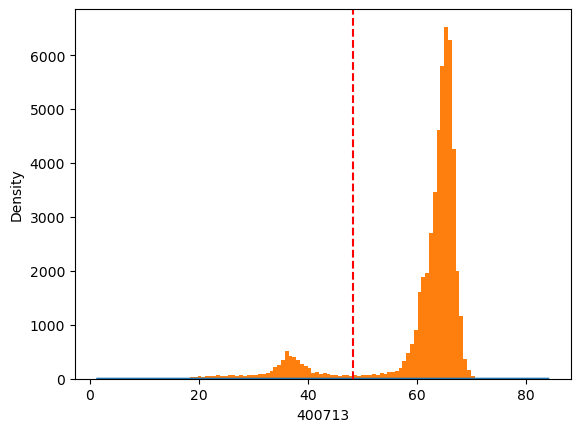

threshold: 49.47706887318384, prop: 0.10703252422527104, mode: 68.3826748521336


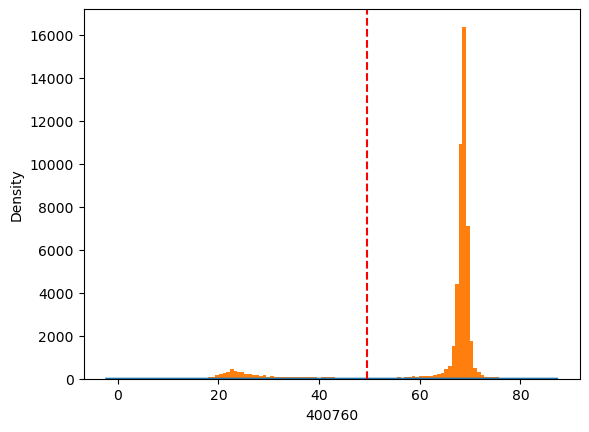

threshold: 50.561179361771906, prop: 0.13775568945005182, mode: 66.16601495264685


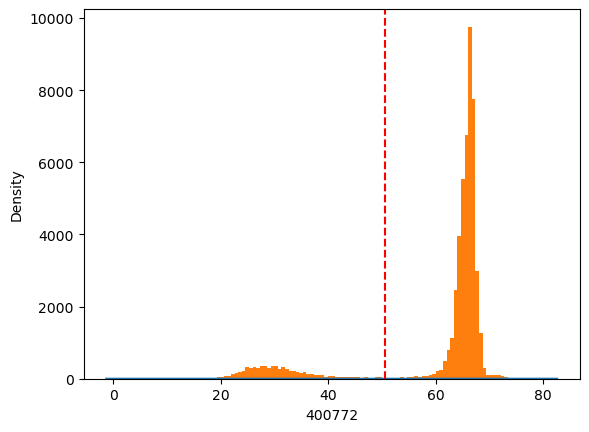

threshold: 42.52100077735943, prop: 0.10553380919487297, mode: 66.98814770638505


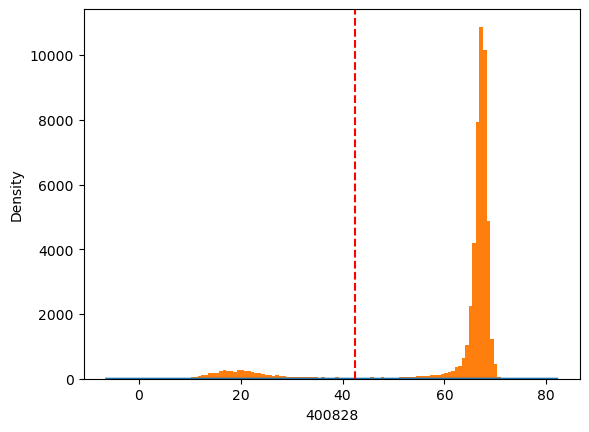

threshold: 48.07807971102852, prop: 0.10565096421375804, mode: 66.59836965799474


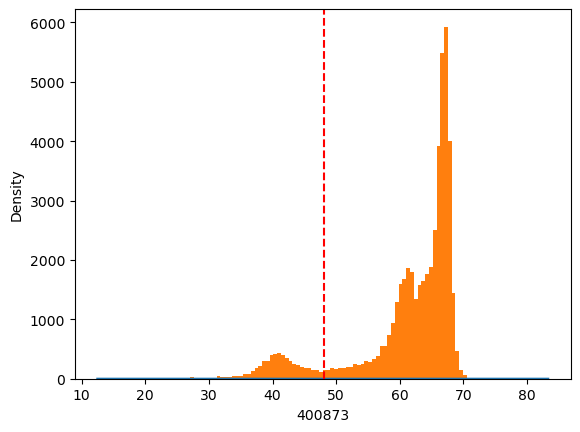

threshold: 39.63878467415907, prop: 0.18162106151897764, mode: 65.11417880147752


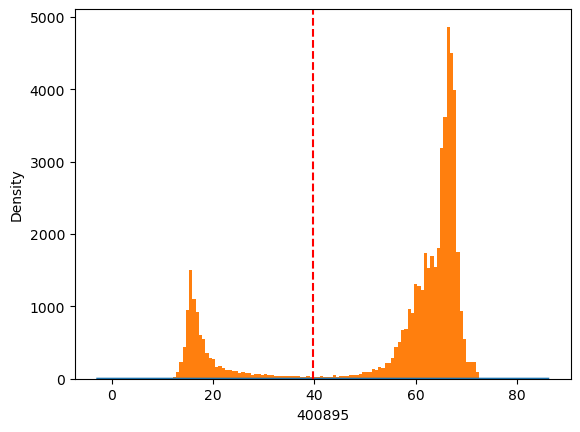

threshold: 46.89000071125323, prop: 0.13744867022297272, mode: 65.43285988626243


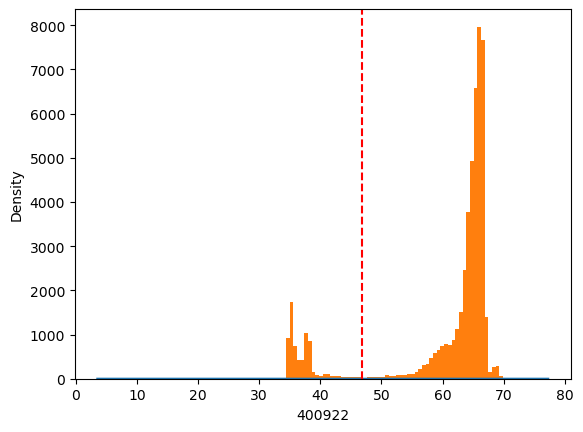

threshold: 49.962427136928845, prop: 0.1261224959705273, mode: 65.80034272198759


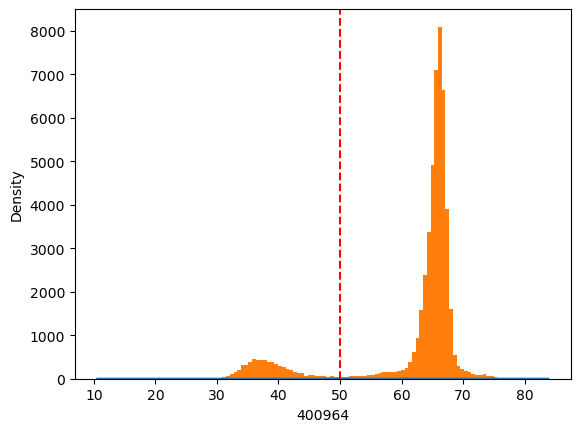

threshold: 54.840115276690405, prop: 0.2098012126794075, mode: 66.32621007444918


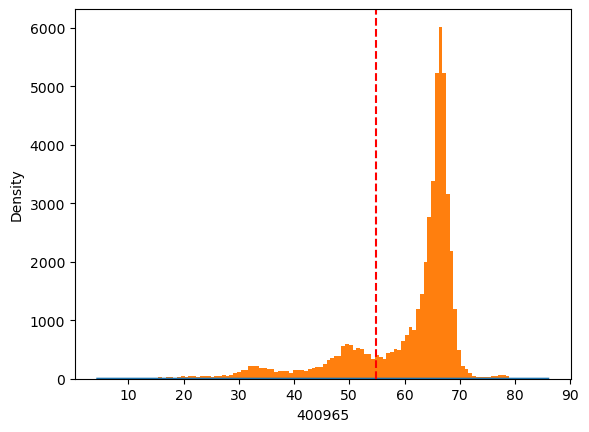

threshold: 35.662471859643766, prop: 0.14543117012702922, mode: 65.07675687815419


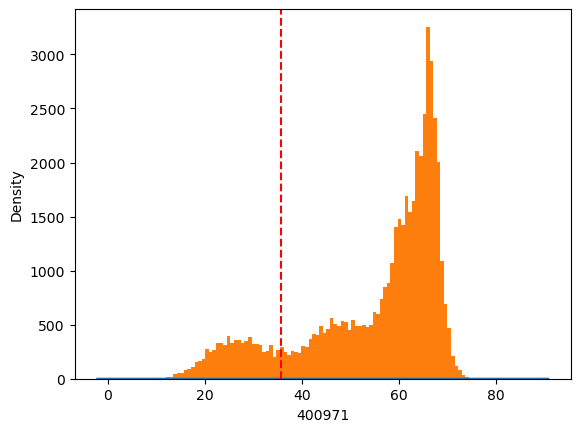

threshold: 42.8775539498485, prop: 0.14562305714395363, mode: 65.83995884911263


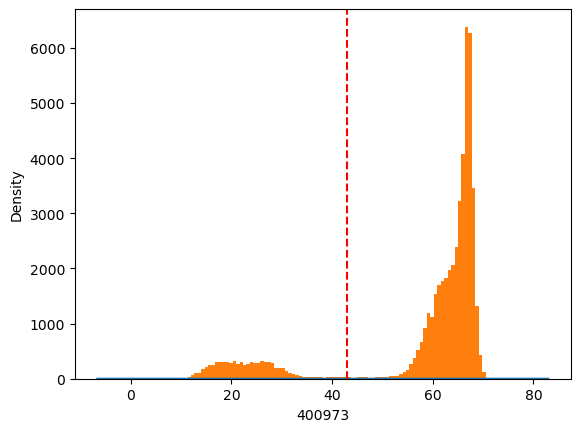

threshold: 49.94969994237497, prop: 0.1172260280544202, mode: 68.95600849894291


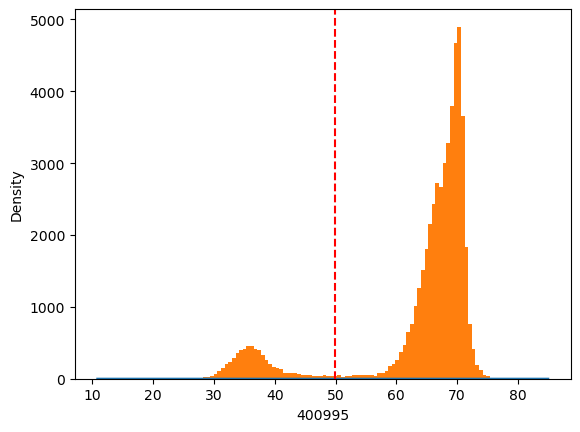

threshold: 48.05179508100535, prop: 0.1638683680322364, mode: 64.642582529088


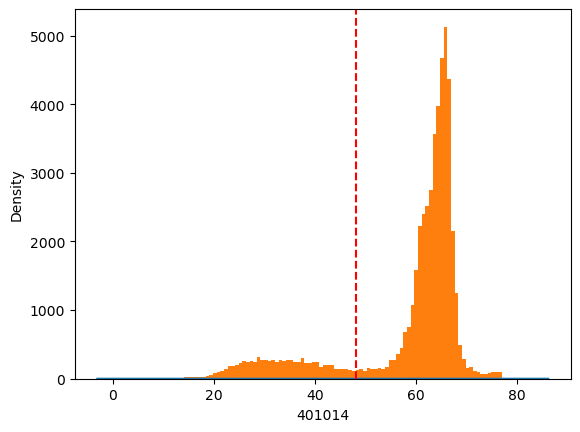

threshold: 40.77748384043294, prop: 0.10897472799493409, mode: 69.42324767485268


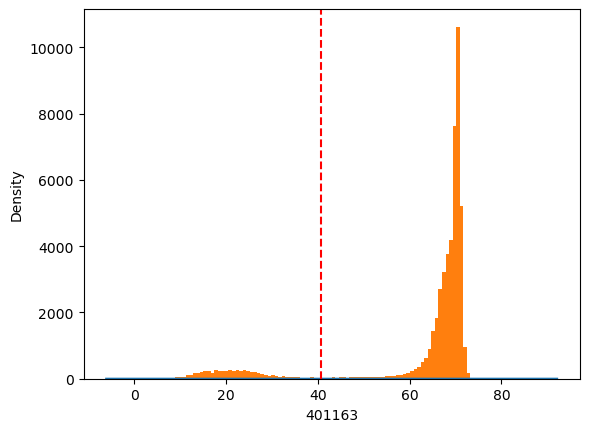

threshold: 50.26055355112104, prop: 0.11739422431161854, mode: 66.8174568822034


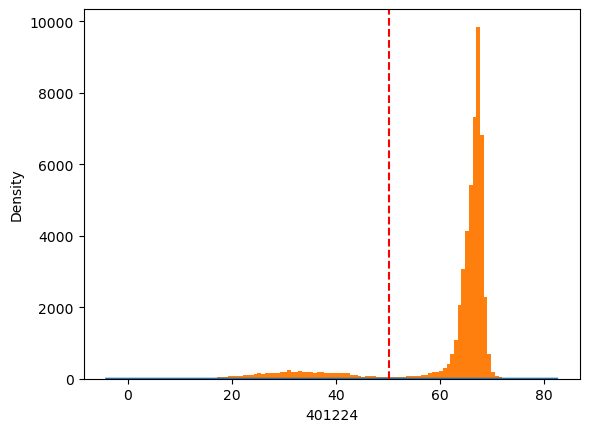

threshold: 44.83379880540849, prop: 0.11990559521068386, mode: 63.99581075132363


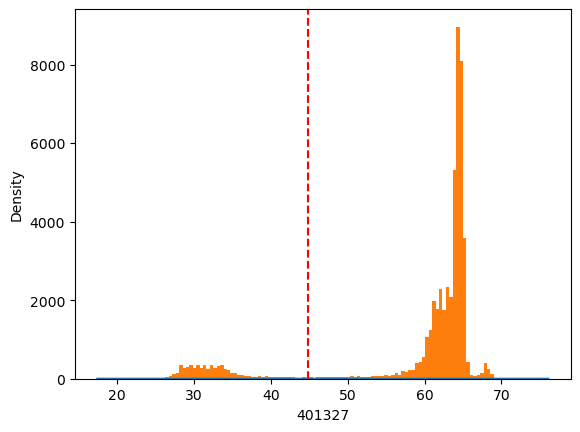

threshold: 51.094862864289965, prop: 0.11311522594262688, mode: 66.62597798266701


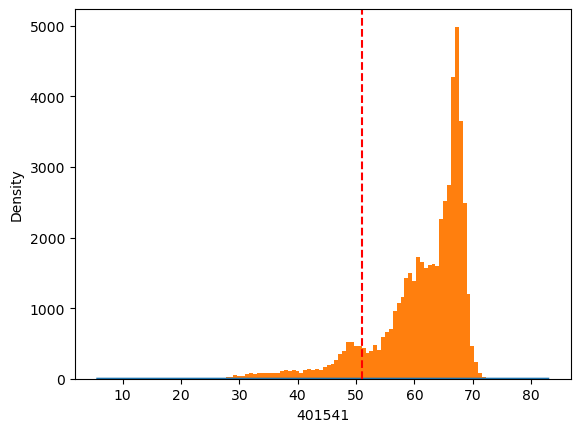

threshold: 43.757113778587545, prop: 0.11252470592750369, mode: 66.4883329844179


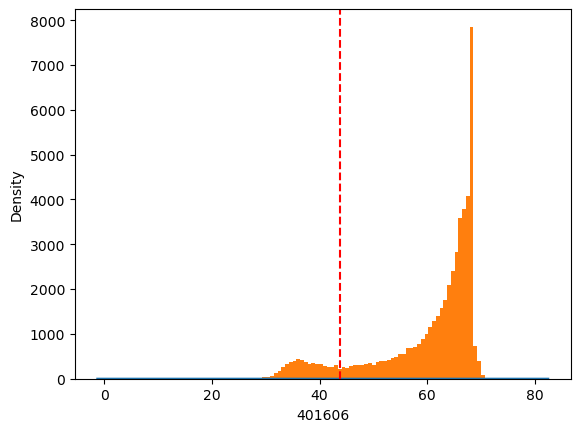

threshold: 51.46132961089439, prop: 0.11766511877806347, mode: 62.95432629570904


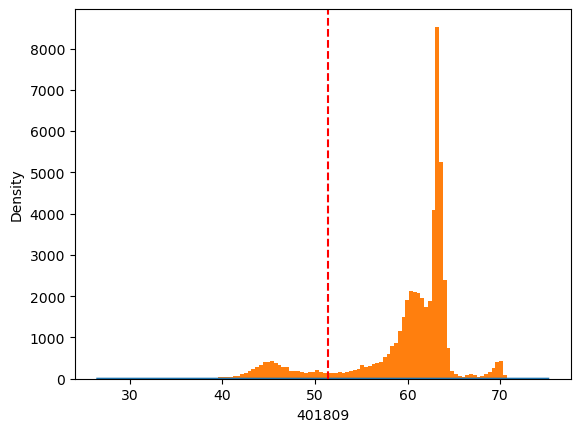

threshold: 37.24750886953752, prop: 0.11445621306316678, mode: 64.95724134606458


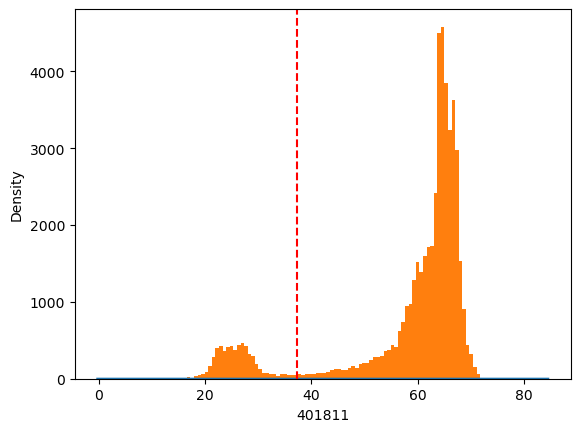

threshold: 55.55498443908328, prop: 0.10083469250695577, mode: 67.70316596131215


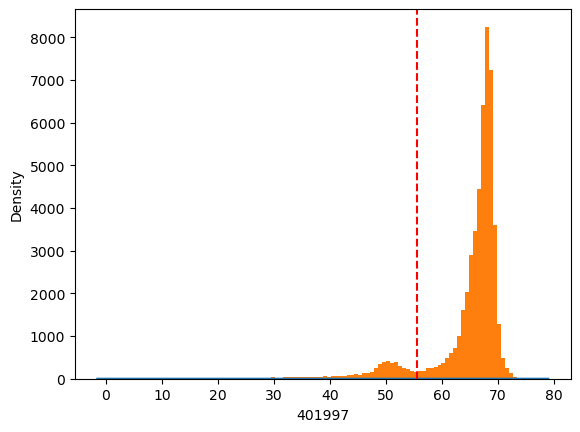

threshold: 50.450409846234706, prop: 0.12921671719691447, mode: 66.49028295812678


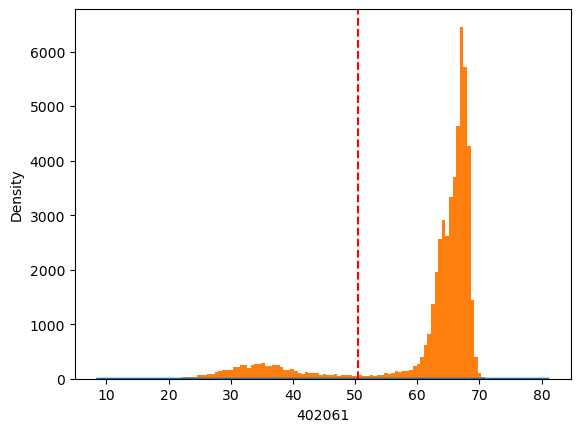

threshold: 40.419831687931406, prop: 0.11724071764367265, mode: 65.81278200515895


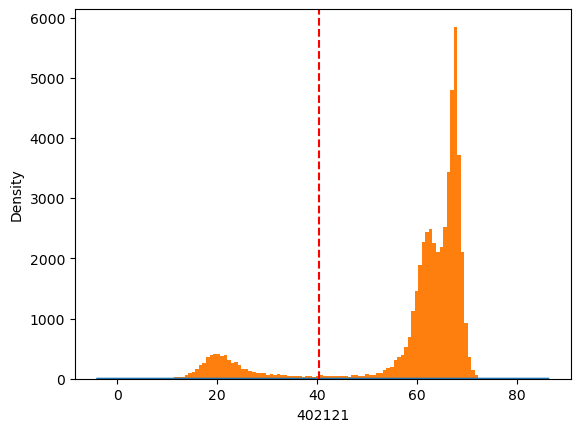

threshold: 42.81726015824935, prop: 0.10716889895229689, mode: 64.6835597426679


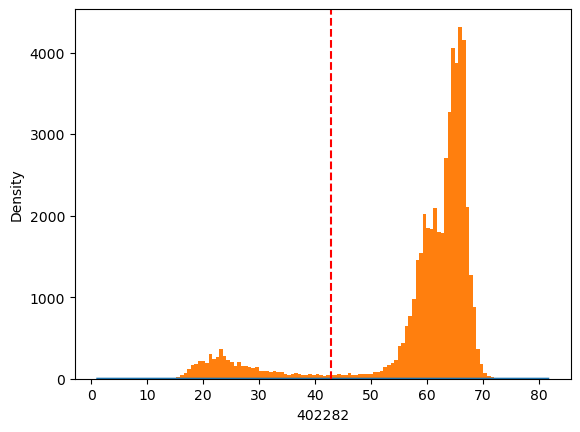

threshold: 47.44929560794511, prop: 0.1053803054724077, mode: 63.725369949873624


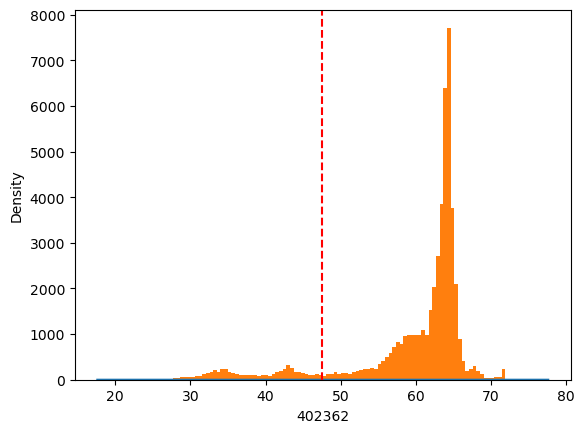

threshold: 48.04466375915462, prop: 0.12252221134841594, mode: 68.70389977005372


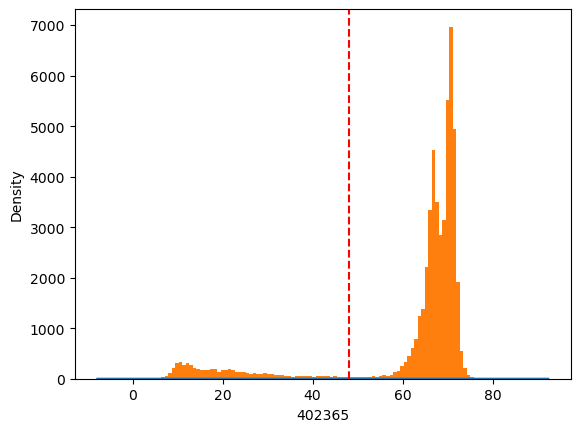

threshold: 47.872233810123134, prop: 0.10179801585017174, mode: 65.23596498385784


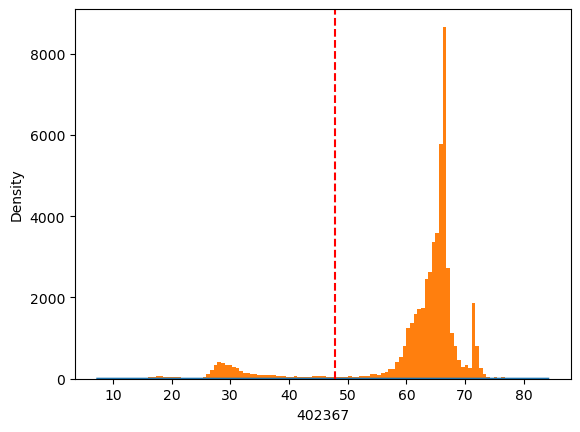

threshold: 52.812120056551, prop: 0.1298090760817423, mode: 65.558244664365


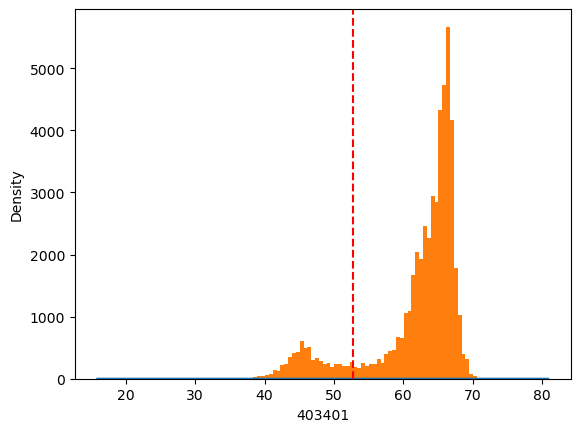

threshold: 47.69400630975498, prop: 0.11710864642898261, mode: 65.36287564659222


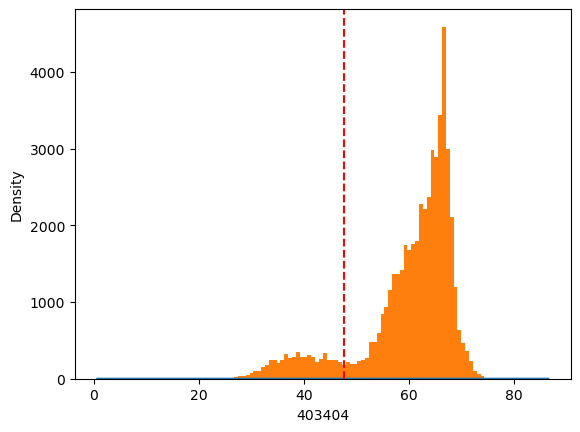

threshold: 40.62373061770949, prop: 0.10642258169746513, mode: 69.26240140618145


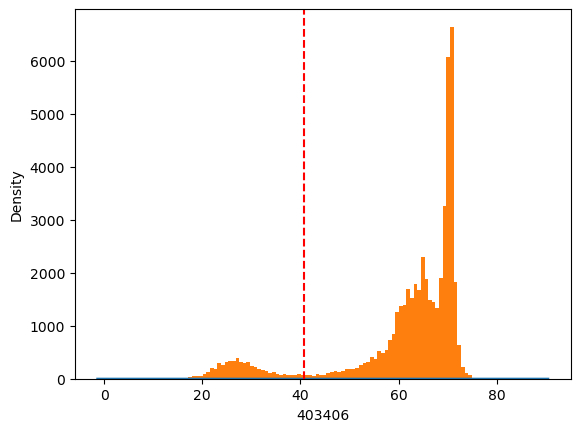

threshold: 47.11538941366702, prop: 0.10787888091491729, mode: 70.31597754403832


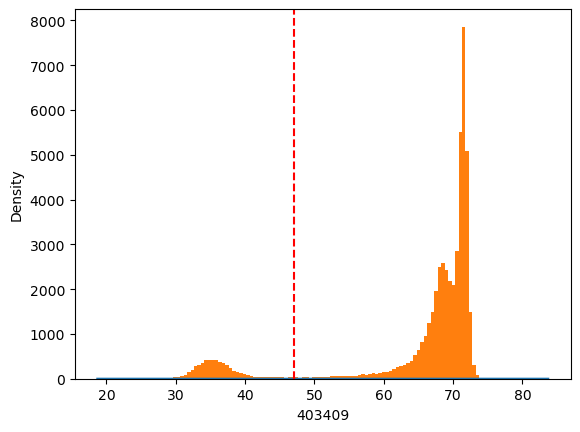

threshold: 36.57532717112837, prop: 0.12837241432244695, mode: 65.49430684729433


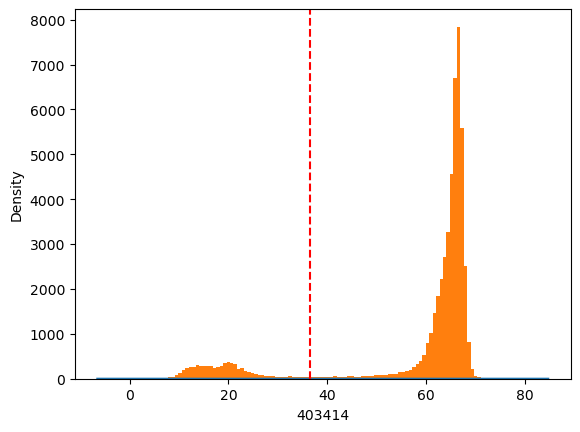

threshold: 48.8018622311283, prop: 0.11672263263935527, mode: 66.09354547314841


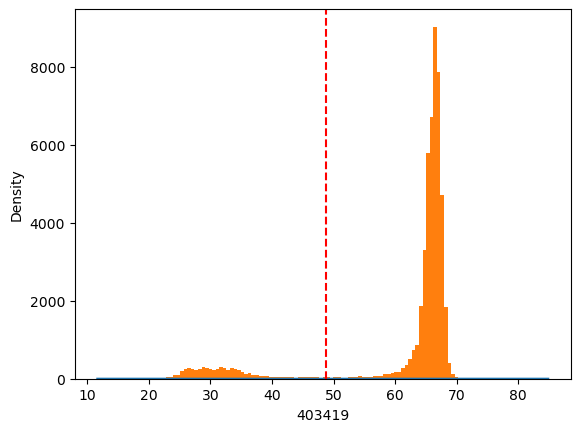

threshold: 50.94265093560143, prop: 0.15777253276533687, mode: 65.59951884973667


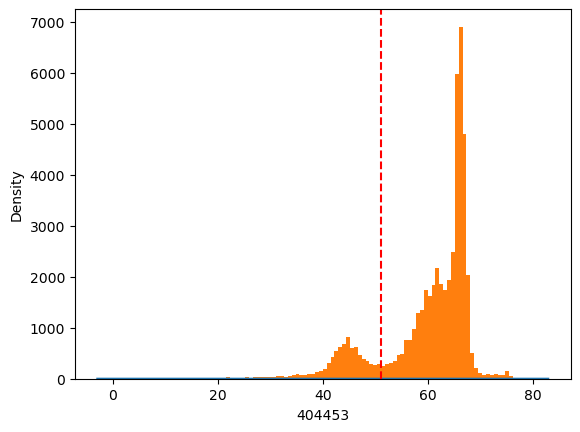

threshold: 49.148805747585754, prop: 0.1261513662879951, mode: 64.92067814035023


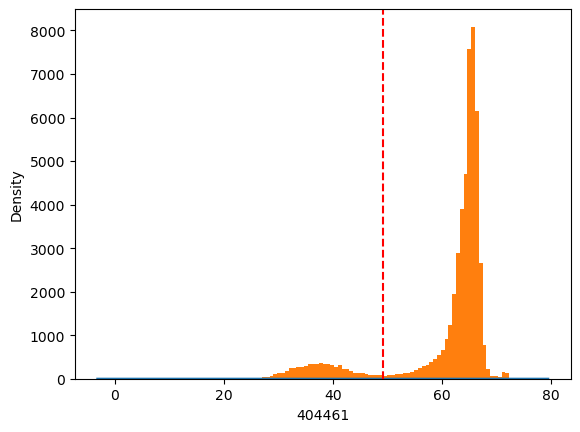

threshold: 56.23460407807857, prop: 0.116130022642668, mode: 67.60180755447341


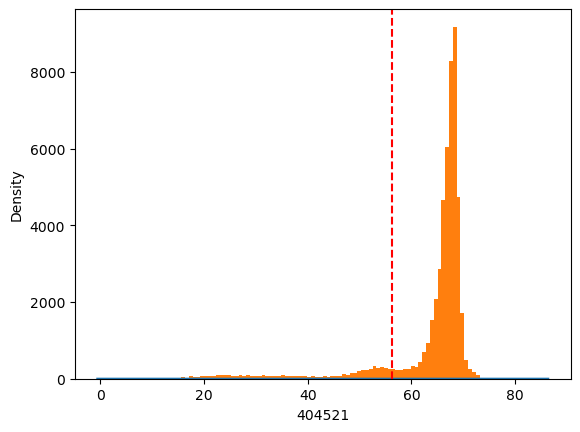

threshold: 51.37434312446547, prop: 0.10455722920464358, mode: 64.08220477857064


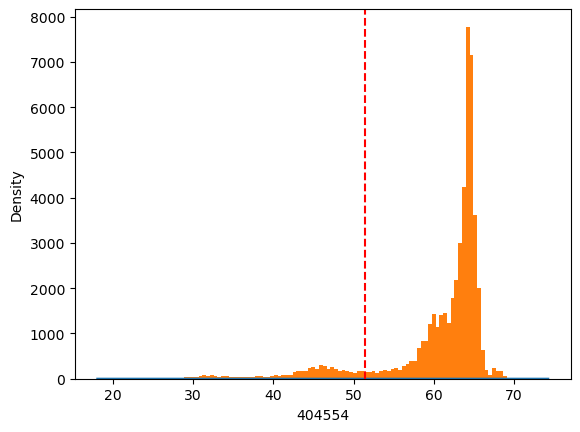

threshold: 51.090085878227676, prop: 0.12328977414464722, mode: 64.4526766723662


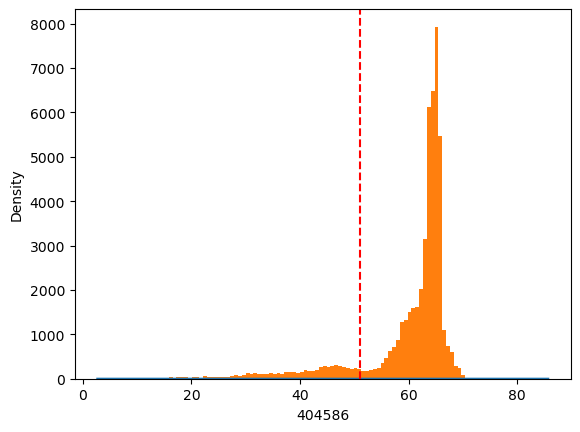

threshold: 50.506306382083665, prop: 0.15750086349157616, mode: 67.2278269605981


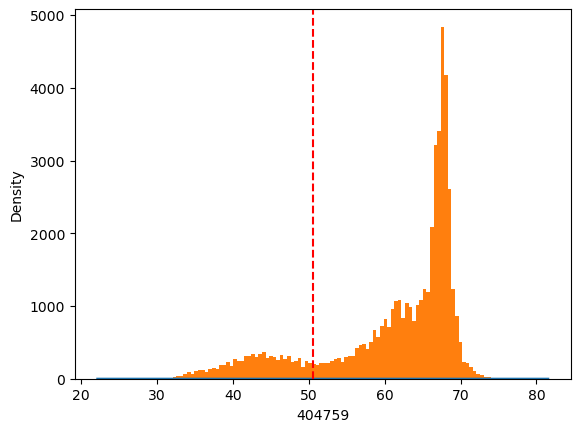

threshold: 49.249361489412976, prop: 0.10557826262161073, mode: 65.44553042589078


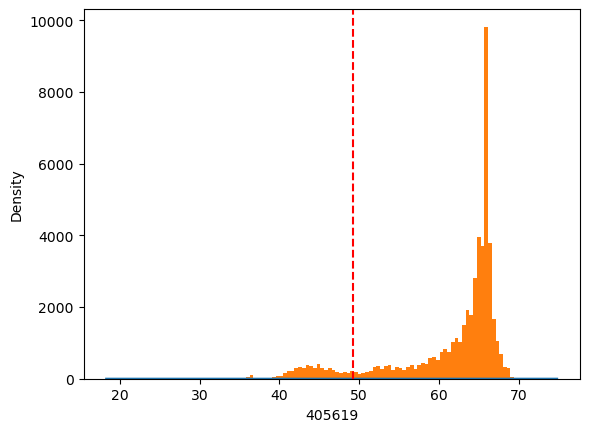

threshold: 42.57537686078991, prop: 0.11108339409755535, mode: 66.28485742135459


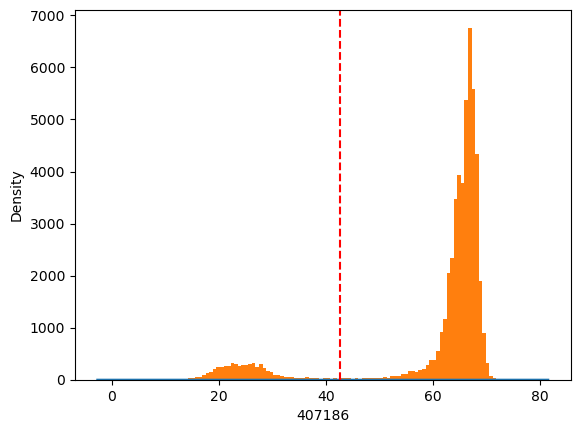

threshold: 50.81304718226865, prop: 0.1168400046052884, mode: 66.35422432955345


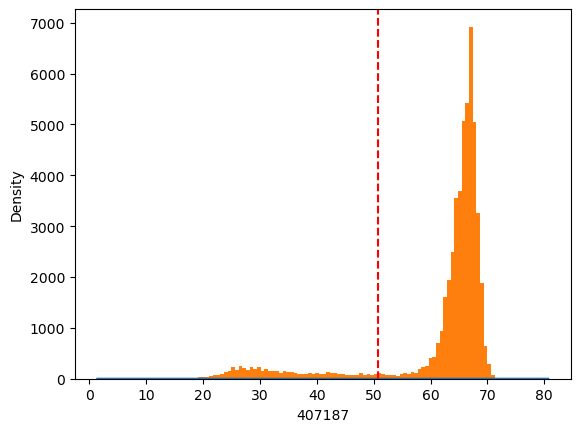

threshold: 52.77205253839834, prop: 0.10283225236980466, mode: 63.74191114990731


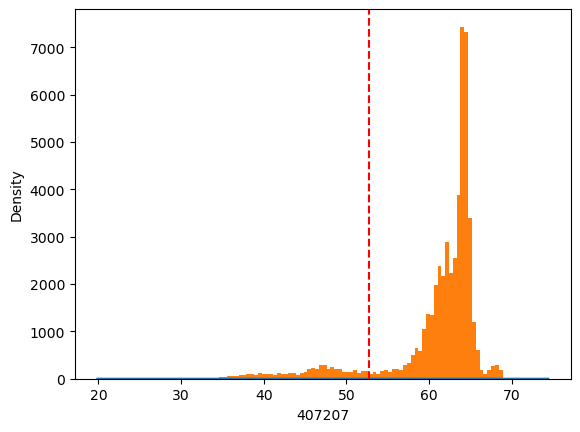

threshold: 48.35470992080922, prop: 0.22088538368545277, mode: 64.14673803343457


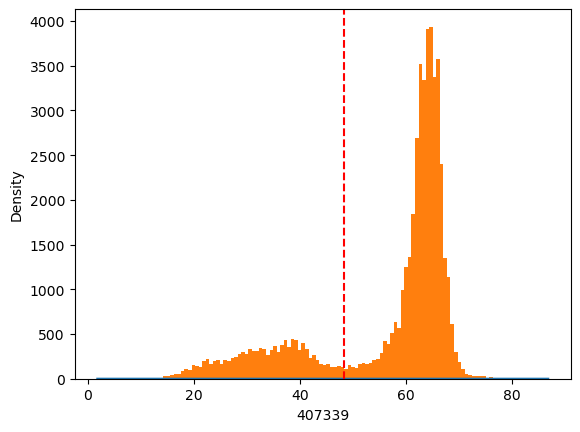

threshold: 49.004154743222884, prop: 0.11872049737114787, mode: 66.04128790241367


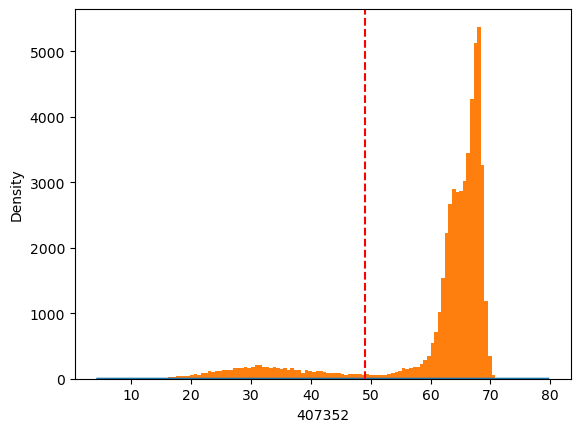

threshold: 43.386910165485084, prop: 0.17312046666922515, mode: 66.68432387705178


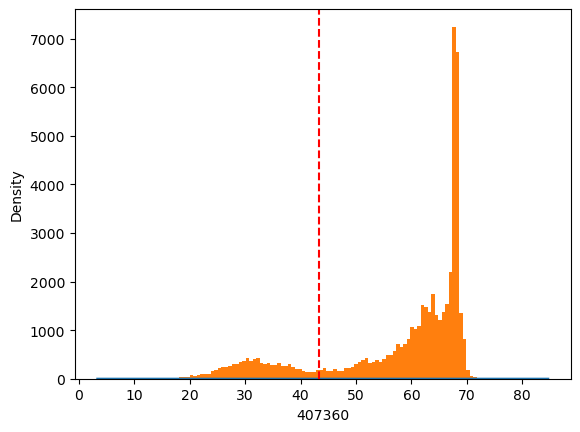

threshold: 44.65234442890248, prop: 0.1724680508116821, mode: 66.50554275037035


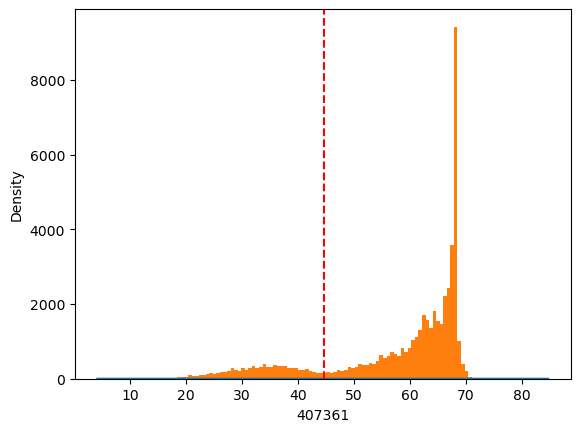

threshold: 45.38871697432593, prop: 0.13062250537304268, mode: 65.43694353915538


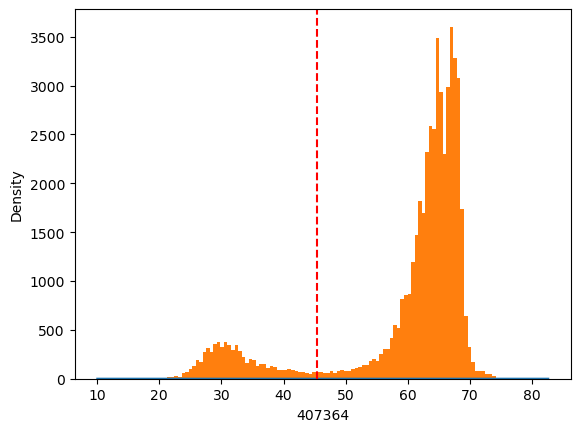

threshold: 47.70967906103437, prop: 0.11526653106650804, mode: 65.11663856989301


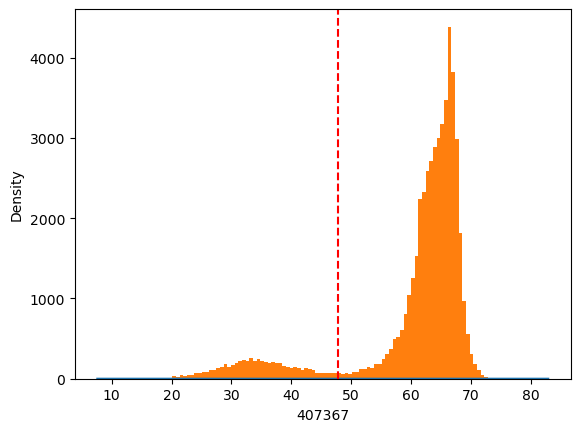

threshold: 48.81284803651494, prop: 0.21424185439613155, mode: 67.1268543970688


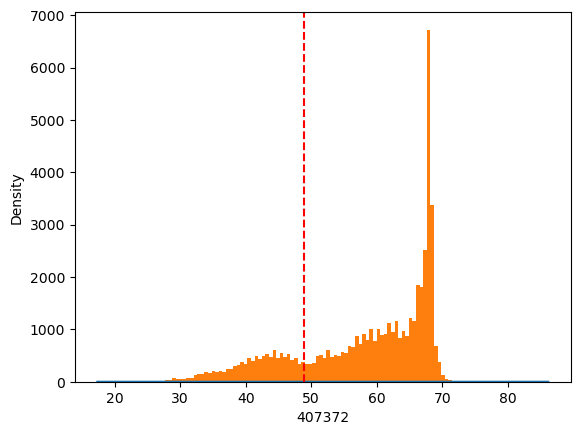

threshold: 46.29463821196977, prop: 0.15059582062057453, mode: 61.080686950146045


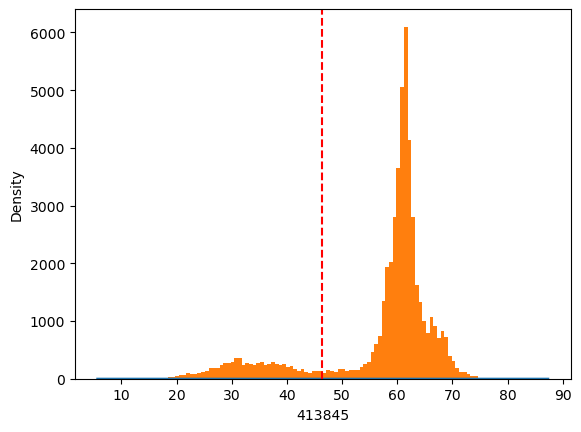

<Figure size 640x480 with 0 Axes>

In [3]:
result = df.apply(is_bimodal, alpha)

In [4]:
if locations_file == f'{data_path}/graph_sensor_locations_bay.csv':
    locations = pd.read_csv(locations_file, header=None)
    locations.columns = ['sensor_id', 'latitude', 'longitude']
    locations = locations.set_index('sensor_id')
else:
    locations = pd.read_csv(locations_file, index_col=1)
locations.index = locations.index.astype(str)
result = pd.DataFrame(result, columns=['Proportion'])
result.index = result.index.astype(str)
merged = pd.concat([locations, result], axis=1)

gdf = gpd.GeoDataFrame(
    merged, geometry=gpd.points_from_xy(merged.longitude, merged.latitude), crs="EPSG:4326"
)

In [5]:
sum(result['Proportion'] > alpha)

79

In [6]:
sum(result['Proportion'] > 0.1)/len(result['Proportion'])

0.24307692307692308

In [7]:
df.columns = df.columns.astype(str)

In [8]:
import pickle
congested = [df.columns.get_loc(c) for c in result[result['Proportion'] > alpha].index if c in df]
pickle.dump(congested, open(f"{data_path}/congested.pkl", "wb"))

<Axes: >

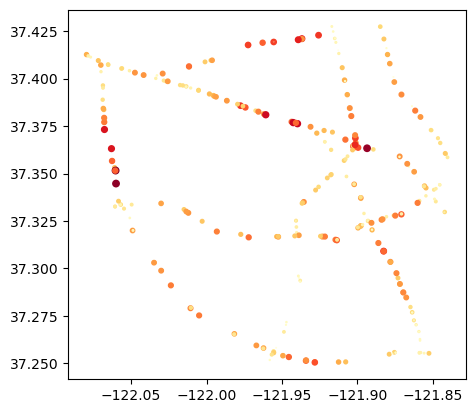

In [9]:
gdf.plot("Proportion", cmap='YlOrRd', markersize=gdf["Proportion"]*100)

In [10]:
gdf.explore("Proportion", cmap='YlOrRd', marker_kwds = {'radius': 10})